In [1]:
pip install dask[dataframe] --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install jaydebeapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 465 kB 5.9 MB/s 


In [3]:
#Importamos Librerias Necesarias
import jaydebeapi
import pandas as pd
import os
import io
import zipfile
import pandas as pd
import subprocess
import glob
import dask.dataframe as dd
import numpy as np
from scipy import stats
from numpy import cov
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.seasonal
import pylab
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
import pandas.util.testing as tm
from pandas import read_csv
from matplotlib import pyplot
import statsmodels.api as sn
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:,.3f}'.format

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


Descargar la serie de tiempo que se encuentra en https://bit.ly/2XMOyQd 
Este es un dataset clásico en el estudio de series de tiempo que informa sobre el número de pasajeros que viajan en avión mes a mes





# Analisis de la Base de Datos

In [4]:
df = pd.DataFrame(pd.read_csv('https://bit.ly/2XMOyQd', sep=',', index_col=0,  header=0, parse_dates=True, squeeze=True))
df.columns=['Pasajeros']
df = df.rename_axis("Fecha")
total_de_anios = df.index.max().year-df.index.min().year

In [5]:
df.head(10)

,Pasajeros
Fecha,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [6]:
print('Numeros de Observaciones:', df.shape[0])

Numeros de Observaciones: 144


In [7]:
print('Estadisticas descriptivas:',df.describe())

Estadisticas descriptivas:        Pasajeros
count    144.000
mean     280.299
std      119.966
min      104.000
25%      180.000
50%      265.500
75%      360.500
max      622.000


In [8]:
print('Informacion de las variables del dataset:', df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Pasajeros  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
Informacion de las variables del dataset: None


In [9]:
print('Tipo de Variables en el dataset:',df.dtypes)

Tipo de Variables en el dataset: Pasajeros    int64
dtype: object


In [10]:
print('Total de Años:', total_de_anios)

Total de Años: 11


La base de datos cuenta con 144 observaciones que con un promedio de 280 pasajeros por mes con un minimo de 104 pasajeros y un maximo de 622 pasajeros. La base de datos parte en enero de 1949 y termina en diciembre de 1960 con un total de 11 años. 

Para analizar la serie de tiempo de la serie de pasajeros primero realizaremos unas inspeccion grafica. 

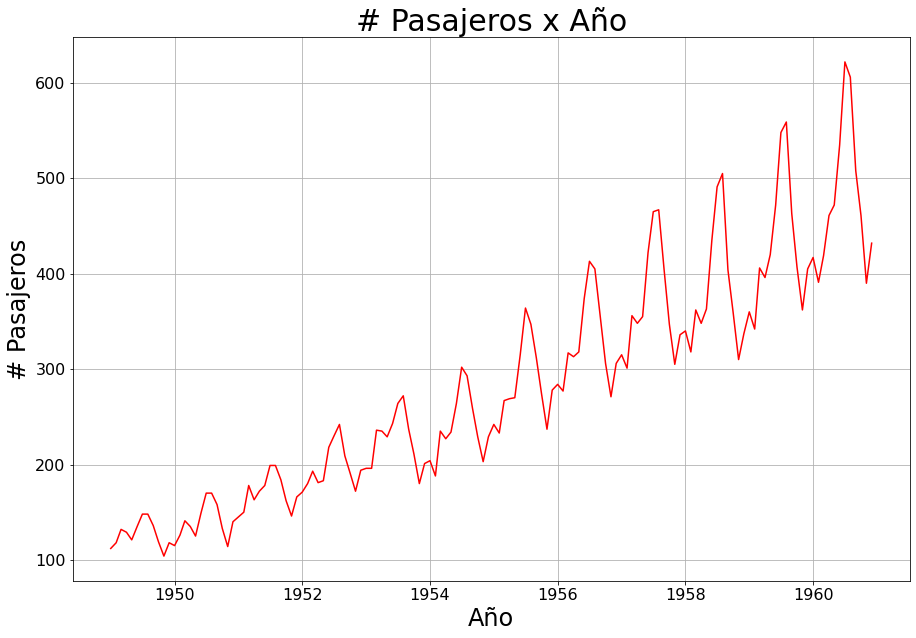

In [11]:
plt.figure(figsize=(15,10))
actual=plt.plot(df, color='red')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show(block=False)

## **Pregunta 1:**
1.1. Comentar acerca de la tendencia

1.2. Comentar acerca de su estacionalidad

1.3. Comentar sobre sus shocks aleatorios, irregularidades, etc.

1.4. Analizar ACF y PACF y comentar acerca de lo que se ve en los correlogramas

# 1.1.   Comentar acerca de la tendencia

# Tendencia: 
La inspección gráfica confirma y revela la la existencia de tendencia en el número de pasajeros. 

La *tendencia* hace referencia al movimiento de una serie hacia valores relativamente más altos o más bajos durante un largo período de tiempo. Por ejemplo, cuando el análisis de las series temporales muestra un patrón ascendente, lo llamamos tendencia ascendente, y cuando el patrón es descendente, lo llamamos tendencia descendente, y si no hubiera ninguna tendencia, lo llamamos tendencia horizontal o estacionaria. 

Para obtener una noción de la tendencia de una serie constriurimos una media media móvil de 12 meses dada la frecuencia de la serie.

In [12]:
rolmean=df.rolling(window=12).mean()
rolstd=df.rolling(window=12).std()

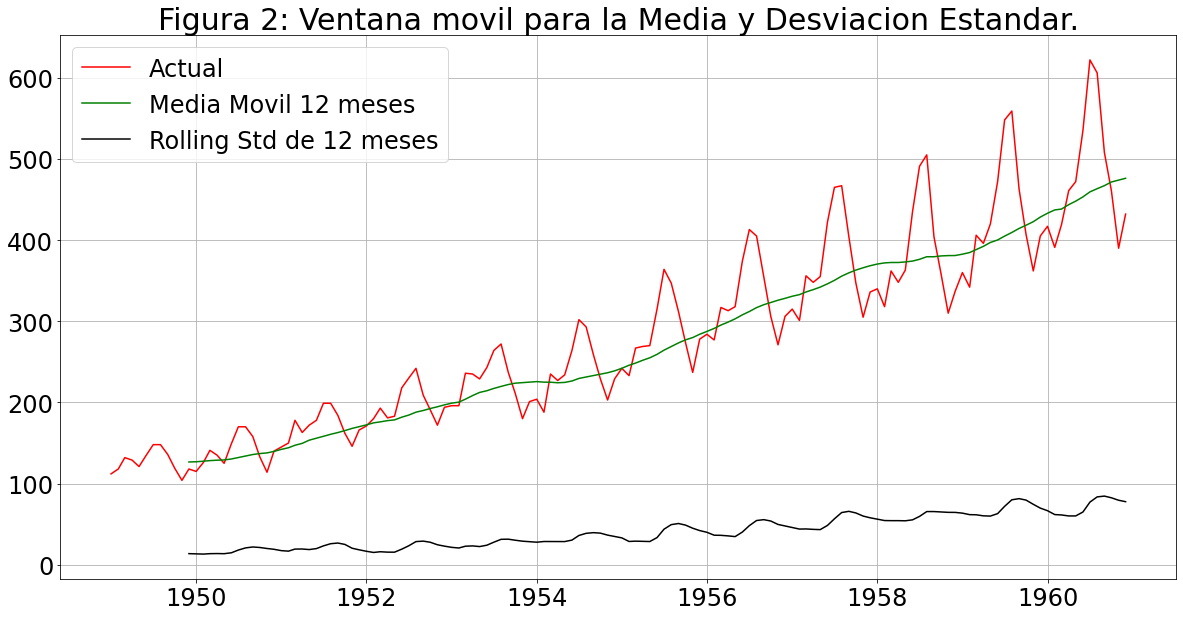

In [13]:
plt.figure(figsize=(20,10))
actual=plt.plot(df, color='red', label='Actual')
mean_12=plt.plot(rolmean, color='green', label='Media Movil 12 meses') 
std_12=plt.plot(rolstd, color='black', label='Rolling Std de 12 meses')
plt.legend(loc=2, prop={'size': 24})
plt.title('Figura 2: Ventana movil para la Media y Desviacion Estandar.', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.show(block=False)

En este ejercicio podemos pareciar con claridad la tendencia creciente de la serie, junto con un aumento en el tiempo de la varianza.

# 1.2. Comentar acerca de su estacionalidad
# Estacionalidad: 

La estacionalidad, se refiere a un patrón que se repite dentro de un periodo de tiempo fijo. Aunque estos patrones también pueden oscilar al alza o a la baja, sin embargo, esto es muy diferente de la tendencia porque la tendencia se mantiene en el tiempo. Sin embargo, la estacionalidad sigue ocurriendo dentro de un periodo de tiempo fijo. 

Para comentar la estacionalidad de la serie de pasajeros presentada anteriormente continuaremos con la inspeccion grafica. Al observar la figura 2, se aprecia un patron que se repite dentro de un periodo fijo de tiempo, un anio. Para confirmar este analisis, mostraremos cual es el mes donde existe el maximo de pasajeros por anio, para ver existe un patron estacional.

In [14]:
df2=df.copy()
df2['year']=df2.index.year
df2['month']=df2.index.month
m = df2.groupby('year')['Pasajeros'].transform('max') == df2['Pasajeros']
df2max = df2.loc[m]
df2max = df2max[['year', 'month', 'year']]
print("Mes en el que se encuentra el maximo de pasajeros:\n",df2max)

Mes en el que se encuentra el maximo de pasajeros:
             year  month  year
Fecha                        
1949-07-01  1949      7  1949
1949-08-01  1949      8  1949
1950-07-01  1950      7  1950
1950-08-01  1950      8  1950
1951-07-01  1951      7  1951
1951-08-01  1951      8  1951
1952-08-01  1952      8  1952
1953-08-01  1953      8  1953
1954-07-01  1954      7  1954
1955-07-01  1955      7  1955
1956-07-01  1956      7  1956
1957-08-01  1957      8  1957
1958-08-01  1958      8  1958
1959-08-01  1959      8  1959
1960-07-01  1960      7  1960


Como se puede observar existe un patron estacional. El numero de pasajeros aumenta, en todos lo anios, en los meses de Julio y/o Agosto.

# 1.3. Comentar sobre sus shocks aleatorios, irregularidades, etc.

# Irregularidad: 
También se denomina ruido. La irregularidad se produce durante un corto periodo de tiempo y no se agota. Para Comentar sobre las irregularidades o shocks aleatorios de la serie realizaremos la descomposicion de la serie de tiempo. Podemos descompobner una serie de tiempo como: 

$y_{t}={NivelBase}_{t}+{Tendencia}_{t}+{Estacionalidad}_{t}+{Irregularidad}_{t}$

Conocido como metodo aditivo o 

$y_{t}={NivelBase}_{t}*{Tendencia}_{t}*{Estacionalidad}_{t}*{Irregularidad}_{t}$

Conocido como metodo multiplicativo

Esta descomposicion permite reforzar los puntos destacados en las preguntas 1 y 2, es decir, existe una tendencia y un marcado componente estacional.

Descomposición de series temporales
Hay un par de modelos a tener en cuenta durante la descomposición de los datos de las series temporales.
1. Modelo aditivo: Este modelo se utiliza cuando las variaciones alrededor de la tendencia no varían con el nivel de la serie temporal. Aquí los componentes de una serie temporal simplemente se suman utilizando la fórmula
y(t) = Nivel(t) + Tendencia(t) + Estacionalidad(t) + Ruido(t)
2. Modelo multiplicativo: Se utiliza si la tendencia es proporcional al nivel de la serie temporal. En este caso, los componentes de una serie temporal se multiplican simplemente mediante la fórmula
y(t) = Nivel(t) * Tendencia(t) * Estacionalidad(t) * Ruido(t)
Para este tutorial, utilizaremos el modelo aditivo porque es rápido de desarrollar, rápido de entrenar y proporciona patrones interpretables. También necesitamos importar statsmodels que tiene un paquete tsa (análisis de series temporales) así como la función seasonal_decompose() que necesitamos:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


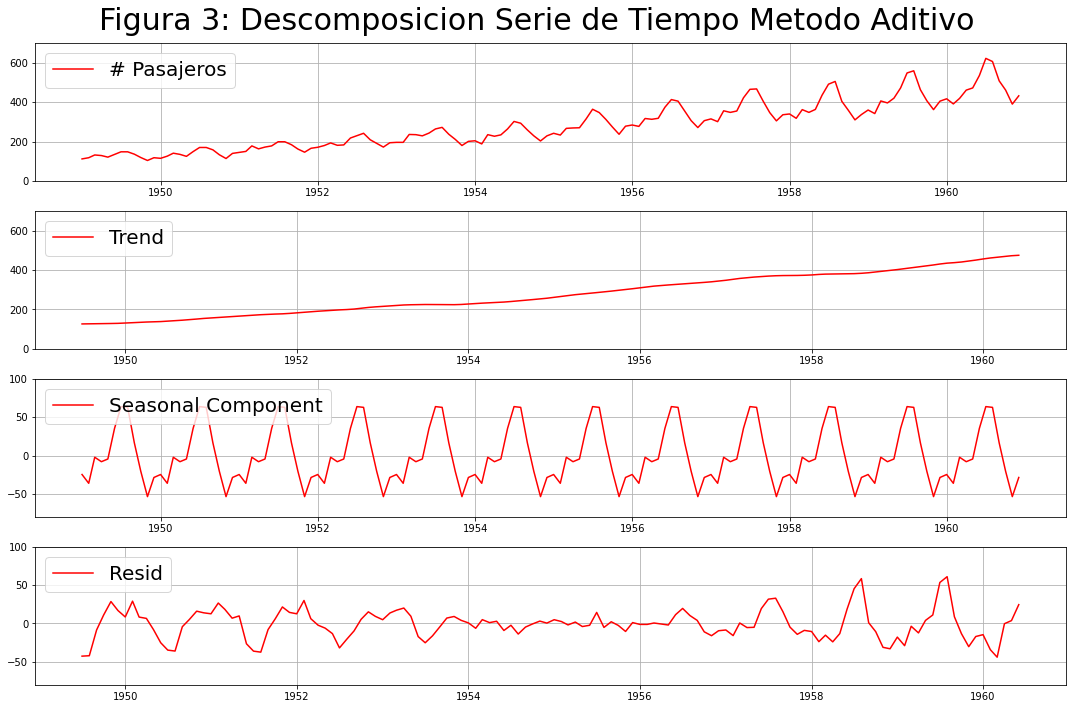

In [15]:
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams['axes.grid'] = True
result_a=seasonal_decompose(df, model='additive', freq=12)
trend=result_a.trend
seasonal=result_a.seasonal
resid=result_a.resid


fig, ax = plt.subplots(4, 1,figsize=(15,10))  
st=fig.suptitle("Figura 3: Descomposicion Serie de Tiempo Metodo Aditivo", fontsize=30)
actual=ax[0].plot(df, color='red', label='# Pasajeros')
ax[0].legend(loc=2)
ax[0].set_ylim([0, 700])
plt.grid(True)
trend_a=ax[1].plot(trend, color='red', label='Trend')
ax[1].legend(loc=2)
ax[1].set_ylim([0, 700])
plt.grid(True)
seasonal_a=ax[2].plot(seasonal, color='red', label='Seasonal Component')
ax[2].legend(loc=2)
ax[2].set_ylim([-80, 100])
plt.grid(True)
resid_a=ax[3].plot(resid, color='red', label='Resid')
ax[3].legend(loc=2)
ax[3].set_ylim([-80, 100])
fig.tight_layout()
fig.subplots_adjust(top=0.93)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


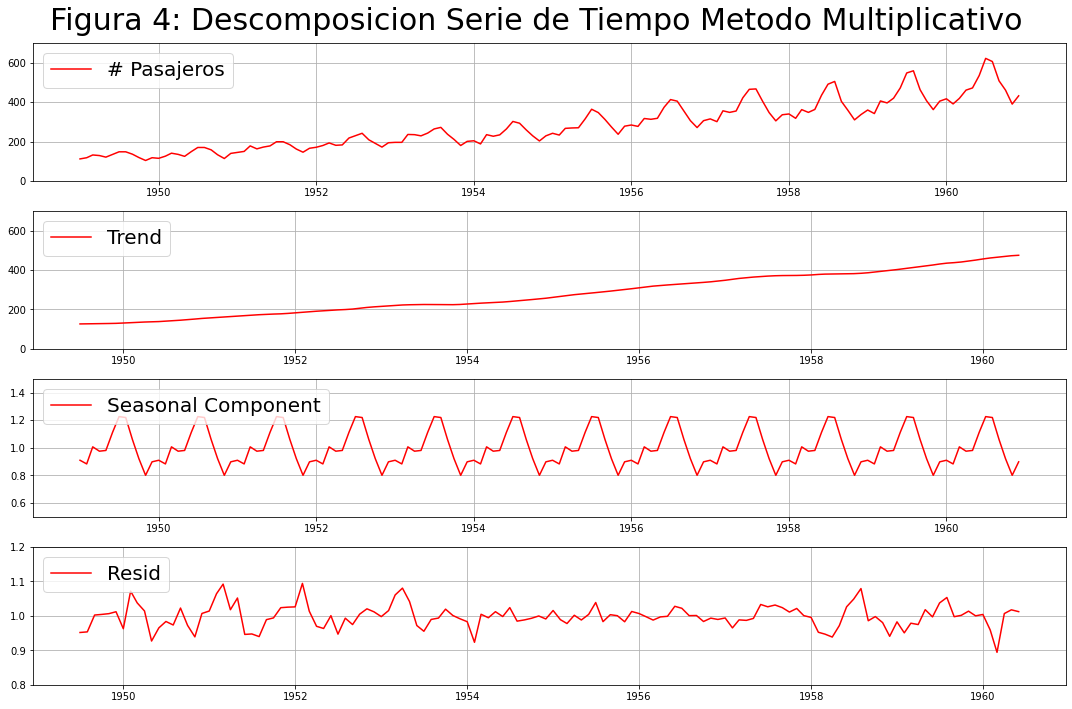

In [16]:
from matplotlib import pyplot as plt
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams['axes.grid'] = True
result_b=seasonal_decompose(df, model='multiplicable', freq=12)
trend=result_b.trend
seasonal=result_b.seasonal
resid=result_b.resid


fig, ax = plt.subplots(4, 1,figsize=(15,10))  
st=fig.suptitle("Figura 4: Descomposicion Serie de Tiempo Metodo Multiplicativo", fontsize=30)
plt.legend(loc=2, prop={'size': 24})
actual=ax[0].plot(df, color='red', label='# Pasajeros')
ax[0].legend(loc=2)
ax[0].set_ylim([0, 700])
plt.grid(True)
trend=ax[1].plot(trend, color='red', label='Trend')
ax[1].legend(loc=2)
ax[1].set_ylim([0, 700])
plt.grid(True)
seasonal=ax[2].plot(seasonal, color='red', label='Seasonal Component')
ax[2].legend(loc=2)
ax[2].set_ylim([0.5, 1.5])
plt.grid(True)
resid=ax[3].plot(resid, color='red', label='Resid')
ax[3].set_ylim([0.8, 1.2])
ax[3].legend(loc=2)
fig.tight_layout()
fig.subplots_adjust(top=0.93)



Si observamos detenidamente los residuos de la descomposición aditiva, tiene algún patrón. Por otro lado, la descomposición multiplicativa, parece bastante aleatoria, lo cual es bueno y deseable. Así que lo ideal sería preferir la descomposición multiplicativa para esta serie en particular.

In [18]:
def stationarity(timeseries):
    print('Dickey-Fuller Test: ')
    dftest=adfuller(df['Pasajeros'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

print('Residuos Metodo Aditivo:\n')
stationarity(result_a.resid.dropna())

Residuos Metodo Aditivo:

Dickey-Fuller Test: 
Test Statistic           0.815
p-value                  0.992
Lags Used               13.000
No. of Obs             130.000
Critical Value (1%)     -3.482
Critical Value (5%)     -2.884
Critical Value (10%)    -2.579
dtype: float64


In [19]:
def stationarity(timeseries):
    print('Dickey-Fuller Test: ')
    dftest=adfuller(df['Pasajeros'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

print('Residuos Metodo Multiplicativo:\n')
stationarity(result_b.resid.dropna())

Residuos Metodo Multiplicativo:

Dickey-Fuller Test: 
Test Statistic           0.815
p-value                  0.992
Lags Used               13.000
No. of Obs             130.000
Critical Value (1%)     -3.482
Critical Value (5%)     -2.884
Critical Value (10%)    -2.579
dtype: float64


Finalmente, comprobando la estacionariedad (es decir, si tienen media y varianza constante en el tiempo, [ver aqui](https://es.wikipedia.org/wiki/Proceso_estacionario)) a traves del test de Dickey-Fuller de los residuos de la serie de tiempo obtenidos a traves del metodo aditivo o multiplicativo, entramos ambos metodos entregan residuos estacionarios.


# 1.4. Analizar ACF y PACF y comentar acerca de lo que se ve en los Correlogramas

La forma habitual de comprobar la estacionalidad de una serie temporal consiste en enb la inspeccion grafica y/o trazar la serie y comprobar si se repiten los patrones en intervalos de tiempo fijos. Así, los tipos de estacionalidad están determinados eventos calendario.

Sin embargo, si queremos una inspección más definitiva de la estacionalidad, utilicemos el gráfico de la función de autocorrelación (ACF). Si existe un fuerte patrón estacional, el gráfico ACF suele revelar alzas repetidas y significativasen losperiodos que son múltiplos de la ventana estacional.


La función de autocorrelación (ACF) nos entrega valores de autocorrelación de cualquier serie con sus valores rezagados. Describe la relacon entre el valor actual de la serie con sus valores pasados. Como se discutio en las preguntas anteriores, una serie de tiempo puede tener componentes como la tendencia, la estacionalidad, la ciclicidad y el residuo. El ACF tiene en cuenta todos estos componentes a la hora de encontrar las correlaciones, por lo que se trata de un "gráfico de autocorrelación completo".

La autocorrelación es simplemente la correlación de una serie con sus propios rezagos. Si una serie está significativamente autocorrelacionada, significa que los valores anteriores de la serie (rezagos) pueden ser útiles para predecir el valor actual.





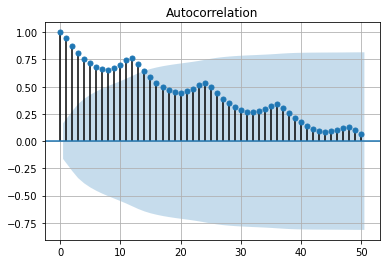

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=50)
pyplot.show()

La región sombreada es el intervalo de confianza con un valor por defecto de $\alpha= 0.05$. Cualquier valor dentro de este rango representa un valor que no tiene una correlación significativa.

En el eje horizontal se muestra el numero de rezagos evaluados y en el eje vertical el valor de la correlación del rezago 'x' con el valor actual de la serie. Como podemos observar el valor de la correlacion disminuye lento evidenciando un alta persistencia de la serie (y la presencia de una marcada tendencia), hasta el rezago 14 existe una correlacion significativa y alta de mas del 50%. Otro hecho importante a destacar es que tambien se puede apreciar la estacionalidad de la serie. Esto se aprecia en que la autocorrelacion disminuyer con el numero de rezagos pero aumenta en el rezago 12 y 13, en linea con lo reportado en las pregunta 1.2 respecto a la estacionalidad en Julio y Agosto. Desde el rezago 15 en adelante la autocorrelacion no es estadisticamenrte significativa.

Es importante destacar que para la cosntruccion de los modelos ARIMA planteados mas adelante en este examen, la serie debera ser diferenciada para transformarla en estacioanria y desestacionalizarla o considerar de alguna forma el efecto estacional.





/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


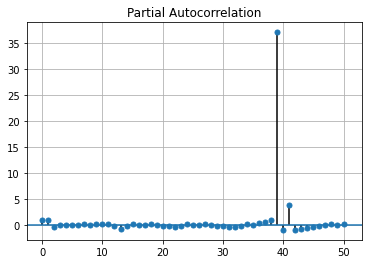

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df, lags=50)
pyplot.show()

La PACF es la función de autocorrelación parcial. Básicamente, en lugar de encontrar correlaciones del valor actual con los rezagos como ACF, encuentra la correlación de los residuos con el valor del siguiente lag, por lo tanto "parcial" y no "completa", ya que eliminamos las variaciones ya encontradas antes de encontrar la siguiente correlación. Por lo tanto, si hay alguna información oculta en el residuo que pueda ser modelada por el siguiente rezago, podríamos obtener una buena correlación y mantendríamos el siguiente rezago como una característica del modelado.

La autocorrelación parcial también transmite información similar, pero transmite la correlación pura de una serie y su rezago, excluyendo las contribuciones de correlación de los rezagos intermedios.

# **Pregunta 2:** Hacer una estimación in-sample usando 

# 1.a)   ARIMA(p,d,q) 




In [23]:
import numpy as np
from statsmodels.tsa.api import ARIMA

# Codigo ARIMA
df_arima = df.copy()
df_arima.reset_index(inplace = True)
print(df_arima)

         Fecha  Pasajeros
0   1949-01-01        112
1   1949-02-01        118
2   1949-03-01        132
3   1949-04-01        129
4   1949-05-01        121
..         ...        ...
139 1960-08-01        606
140 1960-09-01        508
141 1960-10-01        461
142 1960-11-01        390
143 1960-12-01        432

[144 rows x 2 columns]


In [24]:
#### IN-SAMPLE ARIMA
my_order = (1, 1, 1)
modelo = ARIMA(df_arima['Pasajeros'], order = my_order)
results = modelo.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Pasajeros   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -697.073
Method:                       css-mle   S.D. of innovations             31.338
Date:                Wed, 02 Nov 2022   AIC                           1402.145
Time:                        20:15:42   BIC                           1413.997
Sample:                             1   HQIC                          1406.961
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.6112      0.228     11.435      0.000       2.164       3.059
ar.L1.D.Pasajeros     0.7400      0.058     12.778      0.000       0.626       0.854
ma.L1.D.Pasajeros    -1.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


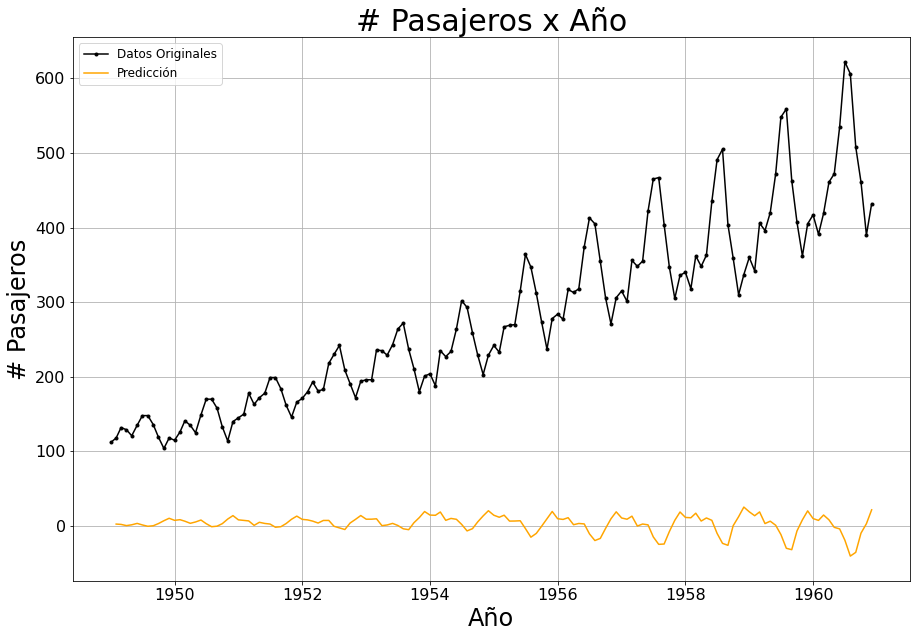

In [25]:
# Prediction of results
prediction_arima = results.fittedvalues

# mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_arima.Fecha, df_arima.Pasajeros, '.-k', label='Datos Originales')
plt.plot(df_arima.Fecha[1:], prediction_arima, 'orange', label='Predicción')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# **Pregunta 2:** Hacer una estimación in-sample usando 

# 1.b)   SARIMA(p,d,q)x(P,D,Q)

In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore")

# Codigo SARIMA
df_sarima = df.copy()
df_sarima.reset_index(inplace = True)
print(df_sarima)

         Fecha  Pasajeros
0   1949-01-01        112
1   1949-02-01        118
2   1949-03-01        132
3   1949-04-01        129
4   1949-05-01        121
..         ...        ...
139 1960-08-01        606
140 1960-09-01        508
141 1960-10-01        461
142 1960-11-01        390
143 1960-12-01        432

[144 rows x 2 columns]


In [27]:
#### IN-SAMPLE SARIMAX 
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 12)
modelo = SARIMAX(np.asarray(df_sarima.Pasajeros), 
                 order = (1,1,1), 
                 seasonal_order = (1,1,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False)
results = modelo.fit()
print(results.summary())



                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -456.103
Date:                            Wed, 02 Nov 2022   AIC                            922.205
Time:                                    20:16:45   BIC                            936.016
Sample:                                         0   HQIC                           927.812
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2298      0.401     -0.573      0.567      -1.016       0.557
ma.L1         -0.0987      0.374   

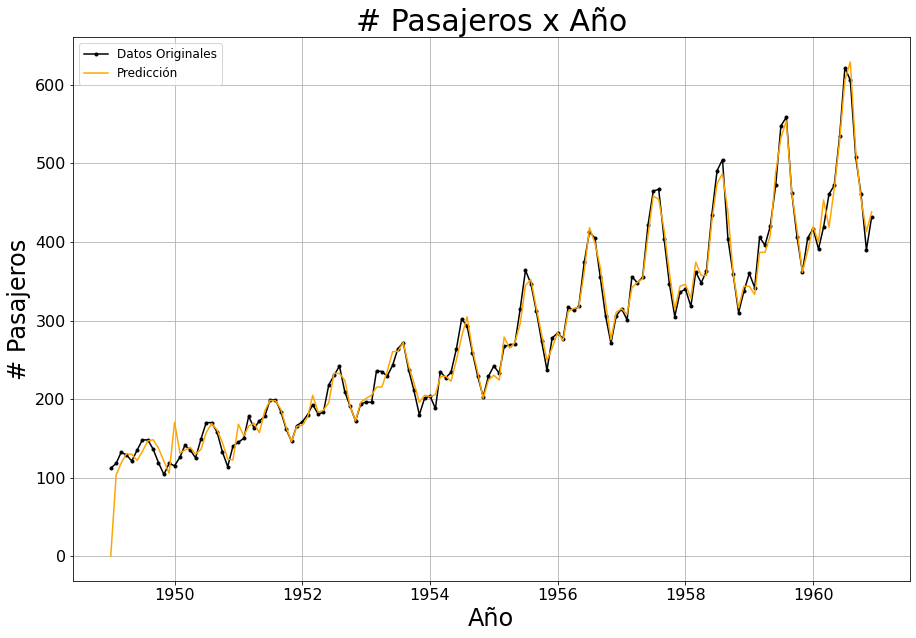

In [28]:
# Prediction of results
prediction = results.fittedvalues

# mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_sarima.Fecha, df_sarima.Pasajeros, '.-k', label='Datos Originales')
plt.plot(df_sarima.Fecha, prediction, 'orange', label='Predicción')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# **Pregunta 2:** Hacer una estimación in-sample usando 

# 2.   Prophet

In [ ]:
# PARA_INSTALAR PROPHET
!pip install Prophet

In [30]:
import prophet
from sklearn.model_selection import ParameterGrid

####### PROPHET
df_prophet = df.copy()
df_prophet.reset_index(inplace = True)
df_prophet.columns = ['ds', 'y']
print(df_prophet)


            ds    y
0   1949-01-01  112
1   1949-02-01  118
2   1949-03-01  132
3   1949-04-01  129
4   1949-05-01  121
..         ...  ...
139 1960-08-01  606
140 1960-09-01  508
141 1960-10-01  461
142 1960-11-01  390
143 1960-12-01  432

[144 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/it2c5x0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/d8x1um_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52926', 'data', 'file=/tmp/tmp9bfp2ekp/it2c5x0w.json', 'init=/tmp/tmp9bfp2ekp/d8x1um_w.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model4impldpj/prophet_model-20221102201722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


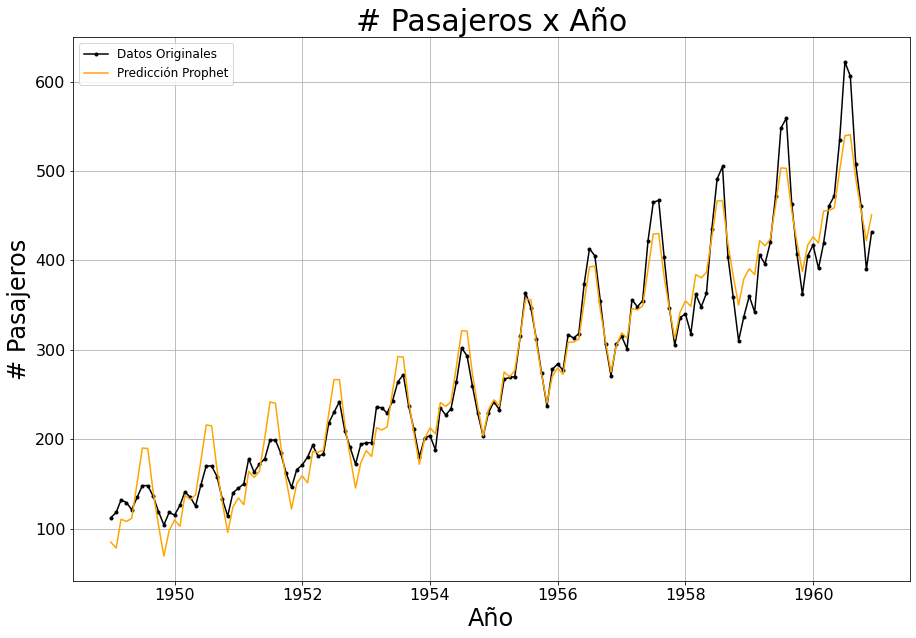

In [31]:
#### in-sample 
modelo_prophet = prophet.Prophet()
modelo_prophet.fit(df_prophet)
pred = modelo_prophet.predict()

# mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_prophet.ds, df_prophet.y, '.-k', label='Datos Originales')
plt.plot(df_prophet.ds, pred.yhat, 'orange', label='Predicción Prophet')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()



# **Pregunta 3 y 4:** Hacer una estimación al futuro (12 periodos) usando  ARIMA(p,d,q). Evaluar el  modelo, calcular errores 

# 1.a)   ARIMA(p,d,q)

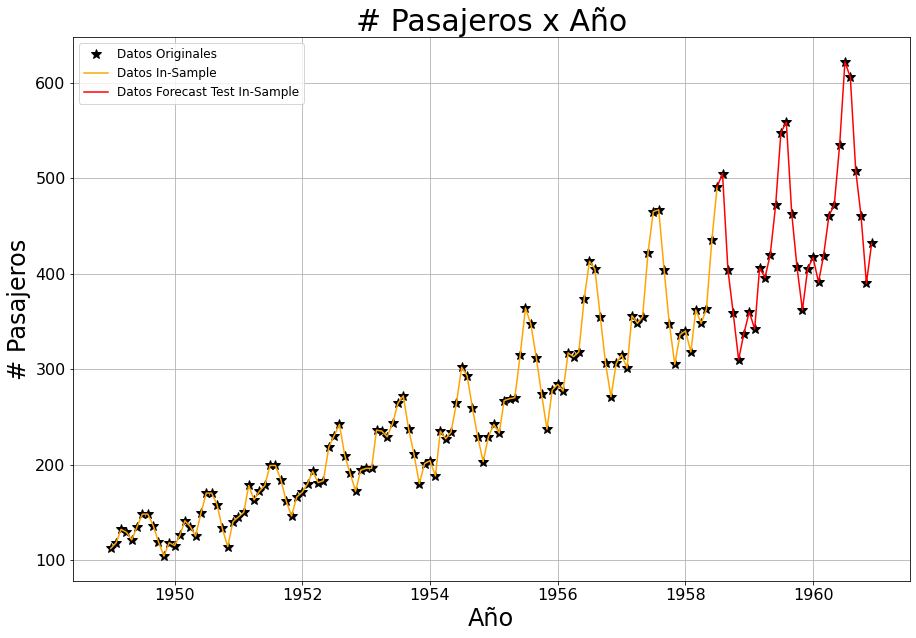

In [32]:
##### out-of-sample, estacionalidad anual
# Tomamos el 20% del total de la data para forecasting 
F = (np.round(df_arima.shape[0]*0.2)).astype(int) 
df_arima['forecast'] = np.nan
df_arima['forecast'][(df_arima.shape[0]-F)-1:df_arima.shape[0]] =  df_arima['Pasajeros'][(df_arima.shape[0]-F)-1:df_arima.shape[0]]  
df_arima['In-Sample'] = np.nan
df_arima['In-Sample'][0:(df_arima.shape[0]-F)] = df_arima['Pasajeros'][0:(df_arima.shape[0]-F)]

# Mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_arima.Fecha, df_arima.Pasajeros, '*k', label='Datos Originales', MarkerSize = 10)
plt.plot(df_arima.Fecha, df_arima['In-Sample'], 'orange', label='Datos In-Sample')
plt.plot(df_arima.Fecha, df_arima.forecast, 'r', label='Datos Forecast Test In-Sample')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [33]:
### Optimizacion de parametros para buscar el resultado con menor error
# valiables p,d,q
p,d,q = range(0,3),[1],range(0,3) 
all_param = list(itertools.product(p, d, q))
print(all_param[0])

(0, 1, 0)


In [34]:
### Buscamos la combinacion de parametros que arroja el menor RMSE
grid_search=[]
for p in all_param:
    m1 = ARIMA( df_arima['In-Sample'][0:(df_arima.shape[0]-F)], order = p)
    results = m1.fit()
    forecast  = results.predict(start = (df_arima.shape[0]-F)-1, end = df_arima.shape[0]-1, dynamic = False)
    time_date = df_arima['Fecha'][(df_arima.shape[0]-F)-1:df_arima.shape[0]]
    real_value = df_arima['Pasajeros'][(df_arima.shape[0]-F)-1:df_arima.shape[0]]
    
    rmse = np.sqrt(mean_squared_error(real_value, forecast))

    validacion_grilla=pd.DataFrame(columns=['p-d-q','rmse'])
    validacion_grilla.loc[0,'p-d-q'] = p
    validacion_grilla.loc[0,'rmse'] = rmse
    grid_search.append(validacion_grilla)
    print(p)

(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)


In [35]:
out_grilla=pd.concat(grid_search)
out_grilla.sort_values(by='rmse', inplace=True)
valor1opt = out_grilla.head(1)['p-d-q'].values
out_grilla

,p-d-q,rmse
0,"(1, 1, 0)",443.861
0,"(0, 1, 1)",444.017
0,"(1, 1, 1)",444.676
0,"(2, 1, 0)",445.117
0,"(0, 1, 0)",445.444
0,"(0, 1, 2)",445.550
0,"(2, 1, 1)",448.903
0,"(1, 1, 2)",449.207
0,"(2, 1, 2)",449.254


In [36]:
print('El RMSE menor es: ', np.array(out_grilla['rmse'])[0])
print('El valor optimo para (p-d-q) son: ', valor1opt[0])

El RMSE menor es:  443.8612685314829
El valor optimo para (p-d-q) son:  (1, 1, 0)


In [37]:
## FORECASTING a FUTURO 12 meses
# agrego 12 filas al dataframe
df_arima_fore  = df_arima.copy()
df_arima_fore = df_arima_fore.set_index('Fecha')
pred_date=[df_arima_fore.index[-1] + DateOffset(months=x)for x in range(0,13)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=df_arima_fore.columns)
pred_date

data=pd.concat([df_arima_fore,pred_date])
data.reset_index(inplace=True)
data.rename({'index': 'Fecha'}, axis=1, inplace=True)
data

,Fecha,Pasajeros,forecast,In-Sample
0,1949-01-01,112,NaN,112.000
1,1949-02-01,118,NaN,118.000
2,1949-03-01,132,NaN,132.000
3,1949-04-01,129,NaN,129.000
4,1949-05-01,121,NaN,121.000
...,...,...,...,...
151,1961-08-01,NaN,NaN,NaN
152,1961-09-01,NaN,NaN,NaN
153,1961-10-01,NaN,NaN,NaN
154,1961-11-01,NaN,NaN,NaN


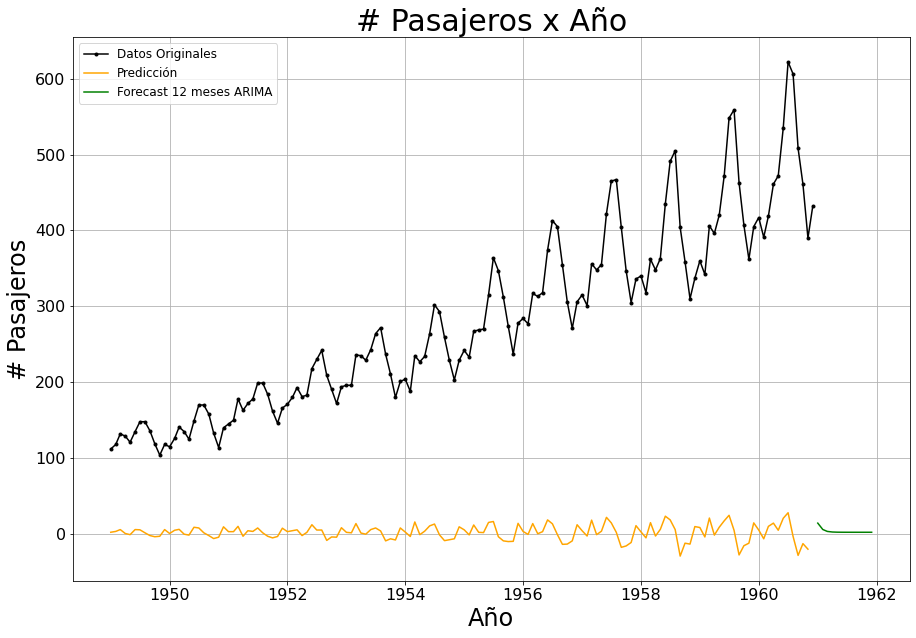

In [38]:
modelo_final = ARIMA( np.asarray(df_arima_fore.Pasajeros), 
                       order = valor1opt[0])

results = modelo_final.fit()
prediction_arima = results.fittedvalues
forecast  = results.predict(start = 144, end = data.shape[0]-1, dynamic = False)
time_date = data['Fecha'][144:]

# mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_arima.Fecha, df_arima.Pasajeros, '.-k', label='Datos Originales')
plt.plot(df_arima.Fecha[0:143], prediction_arima, 'orange', label='Predicción')
plt.plot(time_date, forecast, 'g', label='Forecast 12 meses ARIMA')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# **Pregunta 3 y 4:** Hacer una estimación al futuro (12 periodos) usando  ARIMA(p,d,q). Evaluar el  modelo, calcular errores 

# 1.b)   SARIMA(p,d,q)x(P,D,Q)

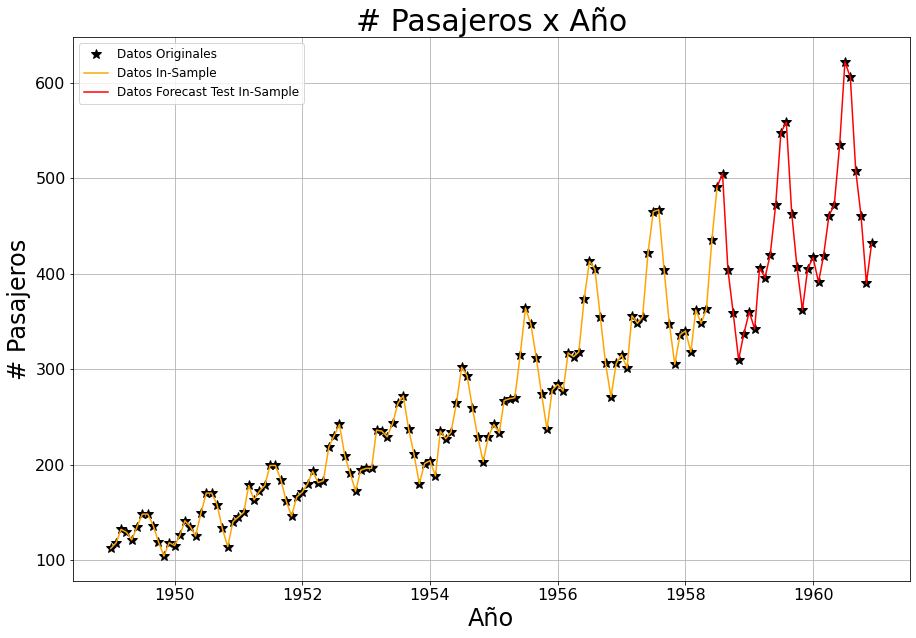

In [39]:
##### out-of-sample, estacionalidad anual
F = (np.round(df_sarima.shape[0]*0.2)).astype(int) # Tomamos el 20% del total de la data para forecasting 
df_sarima['forecast'] = np.nan
df_sarima['forecast'][(df_sarima.shape[0]-F)-1:df_sarima.shape[0]] =  df_sarima['Pasajeros'][(df_sarima.shape[0]-F)-1:df_sarima.shape[0]]  
df_sarima['In-Sample'] = np.nan
df_sarima['In-Sample'][0:(df_sarima.shape[0]-F)] = df_sarima['Pasajeros'][0:(df_sarima.shape[0]-F)]


# mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_sarima.Fecha, df_sarima.Pasajeros, '*k', label='Datos Originales', MarkerSize = 10)
plt.plot(df_sarima.Fecha, df_sarima['In-Sample'], 'orange', label='Datos In-Sample')
plt.plot(df_sarima.Fecha, df_sarima.forecast, 'r', label='Datos Forecast Test In-Sample')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [40]:
### Optimizacion de parametros para buscar el resultado con menor error
p,d,q = range(0,3),[1],range(0,3) # valiables p,d,q
P,D,Q,s = range(0,3),[1],range(0,3),[12] # valiables P,D,Q    
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))
print(all_param[0])

((0, 1, 0), (0, 1, 0, 12))


In [41]:
### buscamos cual combinacion de parametros arroja el menor RMSE
grid_search=[]

for p in all_param:
    m2 = SARIMAX( np.asarray(df_sarima['In-Sample'][0:(df_sarima.shape[0]-F)]), 
                  order = p[0], 
                  seasonal_order = p[1],
                  enforce_stationarity=False,
                  enforce_invertibility=False )
    results = m2.fit()
    forecast  = results.predict(start = (df_sarima.shape[0]-F)-1, end = df_sarima.shape[0]-1, dynamic = False)
    time_date = df_sarima['Fecha'][(df_sarima.shape[0]-F)-1:df_sarima.shape[0]]
    real_value = df_sarima['Pasajeros'][(df_sarima.shape[0]-F)-1:df_sarima.shape[0]]
    
    rmse = np.sqrt(mean_squared_error(real_value, forecast))

    validacion_grilla=pd.DataFrame(columns=['p-d-q','P-D-Q-s','rmse'])
    validacion_grilla.loc[0,'p-d-q'] = p[0]
    validacion_grilla.loc[0,'P-D-Q-s'] = p[1]
    validacion_grilla.loc[0,'rmse'] = rmse
    grid_search.append(validacion_grilla)
    print(p)


((0, 1, 0), (0, 1, 0, 12))
((0, 1, 0), (0, 1, 1, 12))
((0, 1, 0), (0, 1, 2, 12))
((0, 1, 0), (1, 1, 0, 12))
((0, 1, 0), (1, 1, 1, 12))
((0, 1, 0), (1, 1, 2, 12))
((0, 1, 0), (2, 1, 0, 12))
((0, 1, 0), (2, 1, 1, 12))
((0, 1, 0), (2, 1, 2, 12))
((0, 1, 1), (0, 1, 0, 12))
((0, 1, 1), (0, 1, 1, 12))
((0, 1, 1), (0, 1, 2, 12))
((0, 1, 1), (1, 1, 0, 12))
((0, 1, 1), (1, 1, 1, 12))
((0, 1, 1), (1, 1, 2, 12))
((0, 1, 1), (2, 1, 0, 12))
((0, 1, 1), (2, 1, 1, 12))
((0, 1, 1), (2, 1, 2, 12))
((0, 1, 2), (0, 1, 0, 12))
((0, 1, 2), (0, 1, 1, 12))
((0, 1, 2), (0, 1, 2, 12))
((0, 1, 2), (1, 1, 0, 12))
((0, 1, 2), (1, 1, 1, 12))
((0, 1, 2), (1, 1, 2, 12))
((0, 1, 2), (2, 1, 0, 12))
((0, 1, 2), (2, 1, 1, 12))
((0, 1, 2), (2, 1, 2, 12))
((1, 1, 0), (0, 1, 0, 12))
((1, 1, 0), (0, 1, 1, 12))
((1, 1, 0), (0, 1, 2, 12))
((1, 1, 0), (1, 1, 0, 12))
((1, 1, 0), (1, 1, 1, 12))
((1, 1, 0), (1, 1, 2, 12))
((1, 1, 0), (2, 1, 0, 12))
((1, 1, 0), (2, 1, 1, 12))
((1, 1, 0), (2, 1, 2, 12))
((1, 1, 1), (0, 1, 0, 12))
(

In [42]:
out_grilla=pd.concat(grid_search)
out_grilla.sort_values(by='rmse', inplace=True)
valor1opt = out_grilla.head(1)['p-d-q'].values
valor2opt = out_grilla.head(1)['P-D-Q-s'].values

In [43]:
print('El RMSE menor es: ', np.array(out_grilla['rmse'])[0])
print('El valor optimo para (p-d-q) son: ', valor1opt[0])
print('El valor optimo para (P-D-Q-s) es: ', valor2opt[0])

El RMSE menor es:  22.38909901135627
El valor optimo para (p-d-q) son:  (0, 1, 0)
El valor optimo para (P-D-Q-s) es:  (1, 1, 2, 12)


In [44]:
## FORECASTING a FUTURO 12 meses
# agrego 12 filas al dataframe
df_sarima_fore  = df_sarima.copy()
df_sarima_fore = df_sarima_fore.set_index('Fecha')
pred_date=[df_sarima_fore.index[-1] + DateOffset(months=x)for x in range(0,13)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=df_sarima_fore.columns)
pred_date

data=pd.concat([df_sarima_fore,pred_date])
data.reset_index(inplace=True)
data.rename({'index': 'Fecha'}, axis=1, inplace=True)
data

,Fecha,Pasajeros,forecast,In-Sample
0,1949-01-01,112,NaN,112.000
1,1949-02-01,118,NaN,118.000
2,1949-03-01,132,NaN,132.000
3,1949-04-01,129,NaN,129.000
4,1949-05-01,121,NaN,121.000
...,...,...,...,...
151,1961-08-01,NaN,NaN,NaN
152,1961-09-01,NaN,NaN,NaN
153,1961-10-01,NaN,NaN,NaN
154,1961-11-01,NaN,NaN,NaN


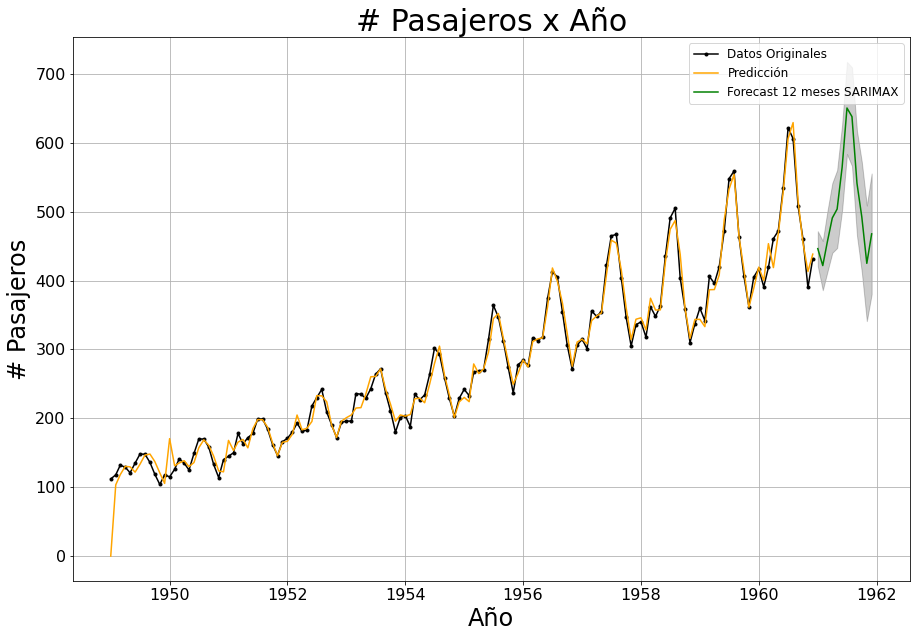

In [45]:
modelo_final = SARIMAX( np.asarray(df_sarima_fore.Pasajeros), 
                        order = valor1opt[0], 
                        seasonal_order = valor2opt[0],
                        enforce_stationarity=False,
                        enforce_invertibility=False )

results = modelo_final.fit()
forecast = results.get_forecast(12)
time_date = data['Fecha'][144:]
pred_ci = forecast.conf_int()


# mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_sarima.Fecha, df_sarima.Pasajeros, '.-k', label='Datos Originales')
plt.plot(df_sarima.Fecha, prediction, 'orange', label='Predicción')
plt.plot(time_date, forecast.predicted_mean, 'g', label='Forecast 12 meses SARIMAX')
plt.fill_between(time_date,
                pred_ci[:, 0],
                pred_ci[:, 1], color='k', alpha=.2)
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# **Pregunta 3 y 4:** Hacer una estimación al futuro (12 periodos) usando  ARIMA(p,d,q). Evaluar el  modelo, calcular errores  

# 2.   ProPhet 

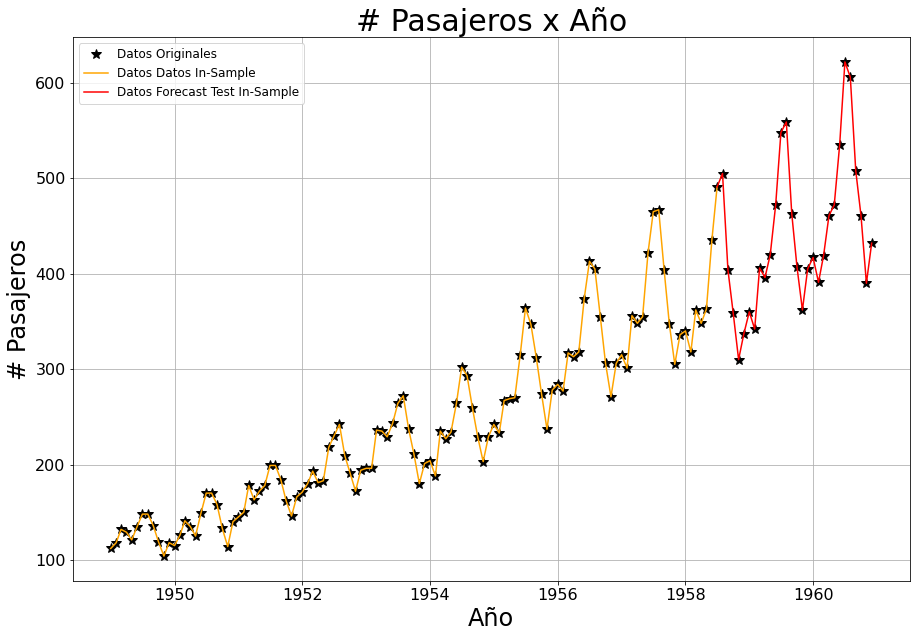

In [46]:
##### Separamos los datos de test para forecasting
F = (np.round(df_prophet.shape[0]*0.2)).astype(int) # Tomamos el 20% del total de la data para forecasting 
df_prophet['forecast'] = np.nan
df_prophet['forecast'] = df_prophet.y[(df_prophet.shape[0]-F)-1:df_prophet.shape[0]]
df_prophet['In-Sample'] = np.nan
df_prophet['In-Sample'][0:(df_prophet.shape[0]-F)] = df_prophet.y[0:(df_prophet.shape[0]-F)]

# mostramos los datos originales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_prophet.ds, df_prophet.y, '*k', label='Datos Originales',MarkerSize = 10)
plt.plot(df_prophet.ds[0:(df_prophet.shape[0]-F)], df_prophet['In-Sample'][0:(df_prophet.shape[0]-F)], 'orange', label='Datos Datos In-Sample')
plt.plot(df_prophet.ds, df_prophet.forecast, 'r', label='Datos Forecast Test In-Sample')
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [47]:
### buscamos cual combinacion de parametros arroja el menor RMSE
escalas_chpoints = [(x/100) for x in range(1,100,10)] # rango de checkpoints     
n_chpoints = [(x) for x in range(2,(df_prophet.shape[0]-F)-1,10)] # number of checkpoints

params_grid = {'changepoint_prior_scale':escalas_chpoints,'n_changepoints': n_chpoints}
grid = ParameterGrid(params_grid)
grid_search=[]

for p in grid:
    m2=prophet.Prophet(**p,seasonality_mode="multiplicative",
                            yearly_seasonality=True,
                            weekly_seasonality=False,
                            daily_seasonality=False)
    m2.fit(df_prophet[['ds','y']][0:(df_prophet.shape[0]-F)])
    forecast=m2.predict(df_prophet[['ds','y']][(df_prophet.shape[0]-F)-1:df_prophet.shape[0]])

    rmse = np.sqrt(mean_squared_error(df_prophet.y[(df_prophet.shape[0]-F)-1:df_prophet.shape[0]], forecast.yhat))

    validacion_grilla=pd.DataFrame(columns=['tipo_changepoint','numero_de_changepoints','mape'])
    validacion_grilla.loc[0,'tipo_changepoint']=p['changepoint_prior_scale']
    validacion_grilla.loc[0,'numero_de_changepoints']=p['n_changepoints']
    validacion_grilla.loc[0,'rmse']=rmse
    grid_search.append(validacion_grilla)
    print(p)

out_grilla=pd.concat(grid_search)
out_grilla.sort_values(by='rmse', inplace=True)
valor1opt=out_grilla.head(1)['tipo_changepoint'].values
valor2opt=out_grilla.head(1)['numero_de_changepoints'].values


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/lu9v9ziy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/7dvrkk41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8370', 'data', 'file=/tmp/tmp9bfp2ekp/lu9v9ziy.json', 'init=/tmp/tmp9bfp2ekp/7dvrkk41.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model80i4zelo/prophet_model-20221102202430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/7ud6rb6s.j

{'changepoint_prior_scale': 0.01, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/dixahypi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/y1yqng2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53014', 'data', 'file=/tmp/tmp9bfp2ekp/dixahypi.json', 'init=/tmp/tmp9bfp2ekp/y1yqng2x.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelzms2dc4g/prophet_model-20221102202431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/c5wd3to6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/dbui72zf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62837', 'data', 'file=/tmp/tmp9bfp2ekp/c5wd3to6.json', 'init=/tmp/tmp9bfp2ekp/dbui72zf.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelz7efrawq/prophet_model-20221102202432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'n_changepoints': 22}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/m3ae3qsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/i04td504.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15231', 'data', 'file=/tmp/tmp9bfp2ekp/m3ae3qsw.json', 'init=/tmp/tmp9bfp2ekp/i04td504.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model4lqb846k/prophet_model-20221102202433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/xvih2wt3.

{'changepoint_prior_scale': 0.01, 'n_changepoints': 32}


20:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/mnn1mtxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/dim1667g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32760', 'data', 'file=/tmp/tmp9bfp2ekp/mnn1mtxu.json', 'init=/tmp/tmp9bfp2ekp/dim1667g.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelkmrm4sw3/prophet_model-20221102202435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during 

{'changepoint_prior_scale': 0.01, 'n_changepoints': 42}


20:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/d0xcnf2a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/j7oh1rjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62115', 'data', 'file=/tmp/tmp9bfp2ekp/d0xcnf2a.json', 'init=/tmp/tmp9bfp2ekp/j7oh1rjd.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeliam9qe6d/prophet_model-20221102202437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during 

{'changepoint_prior_scale': 0.01, 'n_changepoints': 52}


20:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/xrfm0wb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/0ozr2t6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36677', 'data', 'file=/tmp/tmp9bfp2ekp/xrfm0wb8.json', 'init=/tmp/tmp9bfp2ekp/0ozr2t6j.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model63i78j0l/prophet_model-20221102202439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during 

{'changepoint_prior_scale': 0.01, 'n_changepoints': 62}


20:24:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/b7lflp3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/_hvhjc61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94170', 'data', 'file=/tmp/tmp9bfp2ekp/b7lflp3l.json', 'init=/tmp/tmp9bfp2ekp/_hvhjc61.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelir84t01g/prophet_model-20221102202443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during 

{'changepoint_prior_scale': 0.01, 'n_changepoints': 72}


20:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/c1faqwxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/kc3l4o3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3185', 'data', 'file=/tmp/tmp9bfp2ekp/c1faqwxk.json', 'init=/tmp/tmp9bfp2ekp/kc3l4o3_.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelr1052e2s/prophet_model-20221102202447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:47 - cmdstanpy - ERROR - Chain [1] error: error during processing 

{'changepoint_prior_scale': 0.01, 'n_changepoints': 82}


20:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/dvrcuwe0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/tyn6wewi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47420', 'data', 'file=/tmp/tmp9bfp2ekp/dvrcuwe0.json', 'init=/tmp/tmp9bfp2ekp/tyn6wewi.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelh8f17n54/prophet_model-20221102202451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:51 - cmdstanpy - ERROR - Chain [1] error: error during processing

{'changepoint_prior_scale': 0.01, 'n_changepoints': 92}


20:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/r2ork29n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/3r7s6i6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45801', 'data', 'file=/tmp/tmp9bfp2ekp/r2ork29n.json', 'init=/tmp/tmp9bfp2ekp/3r7s6i6p.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model__8guxyy/prophet_model-20221102202455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:24:55 - cmdstanpy - ERROR - Chain [1] error: error during processing

{'changepoint_prior_scale': 0.01, 'n_changepoints': 102}


20:24:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/n73etups.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/8qvd_law.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49319', 'data', 'file=/tmp/tmp9bfp2ekp/n73etups.json', 'init=/tmp/tmp9bfp2ekp/8qvd_law.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelfg7q3cpe/prophet_model-20221102202500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'n_changepoints': 112}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/r2fqhaln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/q41vd1ms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34886', 'data', 'file=/tmp/tmp9bfp2ekp/r2fqhaln.json', 'init=/tmp/tmp9bfp2ekp/q41vd1ms.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelmx3s2emd/prophet_model-20221102202500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ikp_ogbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/3plvj_on.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38011', 'data', 'file=/tmp/tmp9bfp2ekp/ikp_ogbm.json', 'init=/tmp/tmp9bfp2ekp/3plvj_on.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelrg152mut/prophet_model-20221102202501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/akttnfkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/lx3tm7qy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75311', 'data', 'file=/tmp/tmp9bfp2ekp/akttnfkj.json', 'init=/tmp/tmp9bfp2ekp/lx3tm7qy.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelfpi2s884/prophet_model-20221102202502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 22}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/v598p1v6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/mptu2pka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17008', 'data', 'file=/tmp/tmp9bfp2ekp/v598p1v6.json', 'init=/tmp/tmp9bfp2ekp/mptu2pka.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelw6y7zezq/prophet_model-20221102202502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 32}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/g2fwzuyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/5q2oyxr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34681', 'data', 'file=/tmp/tmp9bfp2ekp/g2fwzuyt.json', 'init=/tmp/tmp9bfp2ekp/5q2oyxr_.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelmm8js_yt/prophet_model-20221102202503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 42}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/0ctl1209.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ty_7_sgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73527', 'data', 'file=/tmp/tmp9bfp2ekp/0ctl1209.json', 'init=/tmp/tmp9bfp2ekp/ty_7_sgv.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model4h2vx5hc/prophet_model-20221102202504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 52}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/pid06caf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/_q0oergr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86466', 'data', 'file=/tmp/tmp9bfp2ekp/pid06caf.json', 'init=/tmp/tmp9bfp2ekp/_q0oergr.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model0jxq9lk6/prophet_model-20221102202504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 62}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/u3g7b6ka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/f9xsyt62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52884', 'data', 'file=/tmp/tmp9bfp2ekp/u3g7b6ka.json', 'init=/tmp/tmp9bfp2ekp/f9xsyt62.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model0l49uryd/prophet_model-20221102202505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 72}


INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/tsvx_gcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/mi6l4ltp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95071', 'data', 'file=/tmp/tmp9bfp2ekp/tsvx_gcc.json', 'init=/tmp/tmp9bfp2ekp/mi6l4ltp.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelrh6gdojx/prophet_model-20221102202506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 82}


INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/6mplnqvj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/3qncnnzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95465', 'data', 'file=/tmp/tmp9bfp2ekp/6mplnqvj.json', 'init=/tmp/tmp9bfp2ekp/3qncnnzu.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model_rtwc9m0/prophet_model-20221102202507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 92}


INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/su8p64bb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/47kyp5t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38110', 'data', 'file=/tmp/tmp9bfp2ekp/su8p64bb.json', 'init=/tmp/tmp9bfp2ekp/47kyp5t1.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelzne0oa6j/prophet_model-20221102202507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.11, 'n_changepoints': 102}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/1vfx8fsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/v2udaqqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46487', 'data', 'file=/tmp/tmp9bfp2ekp/1vfx8fsk.json', 'init=/tmp/tmp9bfp2ekp/v2udaqqn.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelwfwxx4fr/prophet_model-20221102202508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:25:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/nmhx45c9.

{'changepoint_prior_scale': 0.11, 'n_changepoints': 112}


20:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/rx1k9r_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vanzs0gg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26564', 'data', 'file=/tmp/tmp9bfp2ekp/rx1k9r_6.json', 'init=/tmp/tmp9bfp2ekp/vanzs0gg.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelf9pobtx5/prophet_model-20221102202509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/iaf8g28p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/pt6w6ga0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15653', 'data', 'file=/tmp/tmp9bfp2ekp/iaf8g28p.json', 'init=/tmp/tmp9bfp2ekp/pt6w6ga0.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelf_cazw7o/prophet_model-20221102202510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/2k6jy1pf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/uah5ajna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8809', 'data', 'file=/tmp/tmp9bfp2ekp/2k6jy1pf.json', 'init=/tmp/tmp9bfp2ekp/uah5ajna.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelt0dtjl08/prophet_model-20221102202510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 22}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/1n_zh1vx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/dlna7265.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94864', 'data', 'file=/tmp/tmp9bfp2ekp/1n_zh1vx.json', 'init=/tmp/tmp9bfp2ekp/dlna7265.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelnribbmfw/prophet_model-20221102202511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 32}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/wefeodrr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/2knpjf9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63255', 'data', 'file=/tmp/tmp9bfp2ekp/wefeodrr.json', 'init=/tmp/tmp9bfp2ekp/2knpjf9a.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model2yyoog62/prophet_model-20221102202512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 42}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/txstsk4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/7w535ia5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57303', 'data', 'file=/tmp/tmp9bfp2ekp/txstsk4q.json', 'init=/tmp/tmp9bfp2ekp/7w535ia5.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model2e4lzi55/prophet_model-20221102202512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 52}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ea_lr6g4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/hx715hjp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23590', 'data', 'file=/tmp/tmp9bfp2ekp/ea_lr6g4.json', 'init=/tmp/tmp9bfp2ekp/hx715hjp.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelogfdhst2/prophet_model-20221102202513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 62}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/le3pwnp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/0a6q10wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67725', 'data', 'file=/tmp/tmp9bfp2ekp/le3pwnp9.json', 'init=/tmp/tmp9bfp2ekp/0a6q10wa.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelgjz00xu0/prophet_model-20221102202514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 72}


INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/yp67fpk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/0dfxm0w3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34872', 'data', 'file=/tmp/tmp9bfp2ekp/yp67fpk8.json', 'init=/tmp/tmp9bfp2ekp/0dfxm0w3.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model2k1vfx6w/prophet_model-20221102202515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 82}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/hz9swxx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/n0wy43l0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40870', 'data', 'file=/tmp/tmp9bfp2ekp/hz9swxx4.json', 'init=/tmp/tmp9bfp2ekp/n0wy43l0.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelon34ay9z/prophet_model-20221102202516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 92}


INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/tp0a61a_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/93e7wj3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18734', 'data', 'file=/tmp/tmp9bfp2ekp/tp0a61a_.json', 'init=/tmp/tmp9bfp2ekp/93e7wj3x.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelif7aeazd/prophet_model-20221102202516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 102}


20:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/306o1_62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/c6rc_p6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15704', 'data', 'file=/tmp/tmp9bfp2ekp/306o1_62.json', 'init=/tmp/tmp9bfp2ekp/c6rc_p6n.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelhxm2s6ek/prophet_model-20221102202517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.21, 'n_changepoints': 112}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/hzsgp0i3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/2vdwmryr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92951', 'data', 'file=/tmp/tmp9bfp2ekp/hzsgp0i3.json', 'init=/tmp/tmp9bfp2ekp/2vdwmryr.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelv59sjumx/prophet_model-20221102202518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/djx42q8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/h4yevb1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67543', 'data', 'file=/tmp/tmp9bfp2ekp/djx42q8l.json', 'init=/tmp/tmp9bfp2ekp/h4yevb1_.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelyyr77oul/prophet_model-20221102202519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/s_bb8j71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/_unz3fgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91293', 'data', 'file=/tmp/tmp9bfp2ekp/s_bb8j71.json', 'init=/tmp/tmp9bfp2ekp/_unz3fgt.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelunn5gfok/prophet_model-20221102202519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 22}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/jle98yfj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/hwkcrbl7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48546', 'data', 'file=/tmp/tmp9bfp2ekp/jle98yfj.json', 'init=/tmp/tmp9bfp2ekp/hwkcrbl7.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model_5zxm81e/prophet_model-20221102202520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 32}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/6832wa03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/d7k_wile.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48636', 'data', 'file=/tmp/tmp9bfp2ekp/6832wa03.json', 'init=/tmp/tmp9bfp2ekp/d7k_wile.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model8fv1tlnf/prophet_model-20221102202521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 42}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/uszc9jth.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/fk3ri1xo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25053', 'data', 'file=/tmp/tmp9bfp2ekp/uszc9jth.json', 'init=/tmp/tmp9bfp2ekp/fk3ri1xo.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelzocuxh6q/prophet_model-20221102202521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 52}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vh0bt4iv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/9prjnkac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63538', 'data', 'file=/tmp/tmp9bfp2ekp/vh0bt4iv.json', 'init=/tmp/tmp9bfp2ekp/9prjnkac.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model0_kb13xs/prophet_model-20221102202522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 62}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ws2jmxjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/0i3j6e41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11419', 'data', 'file=/tmp/tmp9bfp2ekp/ws2jmxjh.json', 'init=/tmp/tmp9bfp2ekp/0i3j6e41.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelm6an4ajg/prophet_model-20221102202523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 72}


INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/59lp40jo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/4i1fhupc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74637', 'data', 'file=/tmp/tmp9bfp2ekp/59lp40jo.json', 'init=/tmp/tmp9bfp2ekp/4i1fhupc.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model3j6pme18/prophet_model-20221102202524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 82}


20:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/t2x8rjd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/fvr1mjxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69375', 'data', 'file=/tmp/tmp9bfp2ekp/t2x8rjd9.json', 'init=/tmp/tmp9bfp2ekp/fvr1mjxn.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelmwhvjet8/prophet_model-20221102202525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 92}


20:25:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/n6x6q65c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/x_4ity78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73250', 'data', 'file=/tmp/tmp9bfp2ekp/n6x6q65c.json', 'init=/tmp/tmp9bfp2ekp/x_4ity78.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model9mwbuoni/prophet_model-20221102202525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 102}


20:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/dj3erf2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/9bfb5vlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44300', 'data', 'file=/tmp/tmp9bfp2ekp/dj3erf2b.json', 'init=/tmp/tmp9bfp2ekp/9bfb5vlz.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelavig2lul/prophet_model-20221102202526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.31, 'n_changepoints': 112}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/lld9tnyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/8qgbwehr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52680', 'data', 'file=/tmp/tmp9bfp2ekp/lld9tnyn.json', 'init=/tmp/tmp9bfp2ekp/8qgbwehr.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelej7vyqnp/prophet_model-20221102202527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/pnf3xpqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/od5tyrll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72643', 'data', 'file=/tmp/tmp9bfp2ekp/pnf3xpqg.json', 'init=/tmp/tmp9bfp2ekp/od5tyrll.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelyotrhauy/prophet_model-20221102202528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 12}


20:25:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/sl67ioee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/gqtfn_8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29900', 'data', 'file=/tmp/tmp9bfp2ekp/sl67ioee.json', 'init=/tmp/tmp9bfp2ekp/gqtfn_8l.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model2f4hmuyq/prophet_model-20221102202529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 22}


20:25:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/64kwcj99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/4d4ijosx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52999', 'data', 'file=/tmp/tmp9bfp2ekp/64kwcj99.json', 'init=/tmp/tmp9bfp2ekp/4d4ijosx.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelyb0q3t8_/prophet_model-20221102202530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 32}


20:25:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/zp098d1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/__rvj08t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18360', 'data', 'file=/tmp/tmp9bfp2ekp/zp098d1q.json', 'init=/tmp/tmp9bfp2ekp/__rvj08t.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model6krzorog/prophet_model-20221102202531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 42}


20:25:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/lwt329yj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/wmpeqe73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85379', 'data', 'file=/tmp/tmp9bfp2ekp/lwt329yj.json', 'init=/tmp/tmp9bfp2ekp/wmpeqe73.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_models_okikld/prophet_model-20221102202532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 52}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/qjiowfkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/xbjwm3dr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15806', 'data', 'file=/tmp/tmp9bfp2ekp/qjiowfkp.json', 'init=/tmp/tmp9bfp2ekp/xbjwm3dr.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelldn2nele/prophet_model-20221102202533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 62}


20:25:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/c5ir59y6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/fq_rqh3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81790', 'data', 'file=/tmp/tmp9bfp2ekp/c5ir59y6.json', 'init=/tmp/tmp9bfp2ekp/fq_rqh3v.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model_o4lgtld/prophet_model-20221102202534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 72}


20:25:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/mi0qz1ue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/jleqt1am.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77199', 'data', 'file=/tmp/tmp9bfp2ekp/mi0qz1ue.json', 'init=/tmp/tmp9bfp2ekp/jleqt1am.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelceejh788/prophet_model-20221102202535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 82}


20:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/6ean08wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/q9syagy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38907', 'data', 'file=/tmp/tmp9bfp2ekp/6ean08wy.json', 'init=/tmp/tmp9bfp2ekp/q9syagy1.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelsppr61sy/prophet_model-20221102202535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 92}


20:25:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/7lvgv_wh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vt7lpg_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21827', 'data', 'file=/tmp/tmp9bfp2ekp/7lvgv_wh.json', 'init=/tmp/tmp9bfp2ekp/vt7lpg_0.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeli2zatp_n/prophet_model-20221102202536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 102}


20:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vp7blnev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/7eu4_9y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58974', 'data', 'file=/tmp/tmp9bfp2ekp/vp7blnev.json', 'init=/tmp/tmp9bfp2ekp/7eu4_9y1.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeltbyvidto/prophet_model-20221102202537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.41, 'n_changepoints': 112}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/s0c37obv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vash87_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2891', 'data', 'file=/tmp/tmp9bfp2ekp/s0c37obv.json', 'init=/tmp/tmp9bfp2ekp/vash87_g.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelhj0xu9oy/prophet_model-20221102202538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/at23n2aq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/g20j0wbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61680', 'data', 'file=/tmp/tmp9bfp2ekp/at23n2aq.json', 'init=/tmp/tmp9bfp2ekp/g20j0wbf.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model6xyesoic/prophet_model-20221102202539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ipi6ubby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/kaukd363.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43805', 'data', 'file=/tmp/tmp9bfp2ekp/ipi6ubby.json', 'init=/tmp/tmp9bfp2ekp/kaukd363.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model5x1f9juo/prophet_model-20221102202539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 22}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/3fock7v5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/yur_w9u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6377', 'data', 'file=/tmp/tmp9bfp2ekp/3fock7v5.json', 'init=/tmp/tmp9bfp2ekp/yur_w9u7.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model0z2zssib/prophet_model-20221102202540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 32}


20:25:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/64k58026.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/9tblwxkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96835', 'data', 'file=/tmp/tmp9bfp2ekp/64k58026.json', 'init=/tmp/tmp9bfp2ekp/9tblwxkw.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelhrirxpt8/prophet_model-20221102202541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 42}


20:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/d20by4eb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ukra9g94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7710', 'data', 'file=/tmp/tmp9bfp2ekp/d20by4eb.json', 'init=/tmp/tmp9bfp2ekp/ukra9g94.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelviy7r33v/prophet_model-20221102202542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 52}


20:25:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/m318cfra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/q7fc50ne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69819', 'data', 'file=/tmp/tmp9bfp2ekp/m318cfra.json', 'init=/tmp/tmp9bfp2ekp/q7fc50ne.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model1s3tpxby/prophet_model-20221102202542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 62}


20:25:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vbl4cbjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vm5ynrlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69712', 'data', 'file=/tmp/tmp9bfp2ekp/vbl4cbjj.json', 'init=/tmp/tmp9bfp2ekp/vm5ynrlz.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model4q3bxhmg/prophet_model-20221102202543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 72}


20:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/t8en33qx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ui_s8fyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90360', 'data', 'file=/tmp/tmp9bfp2ekp/t8en33qx.json', 'init=/tmp/tmp9bfp2ekp/ui_s8fyq.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelg5idq375/prophet_model-20221102202544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 82}


20:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/h4fv7u9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/70qfxjvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23911', 'data', 'file=/tmp/tmp9bfp2ekp/h4fv7u9b.json', 'init=/tmp/tmp9bfp2ekp/70qfxjvl.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modely2lddpru/prophet_model-20221102202545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 92}


20:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/37cdb243.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/j64i0k6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99447', 'data', 'file=/tmp/tmp9bfp2ekp/37cdb243.json', 'init=/tmp/tmp9bfp2ekp/j64i0k6y.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model3va6fqhe/prophet_model-20221102202546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.51, 'n_changepoints': 102}


20:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/i0du0du3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/730qzddq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12542', 'data', 'file=/tmp/tmp9bfp2ekp/i0du0du3.json', 'init=/tmp/tmp9bfp2ekp/730qzddq.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model7p8dw74r/prophet_model-20221102202547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:25:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during 

{'changepoint_prior_scale': 0.51, 'n_changepoints': 112}


20:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/z35se8mg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/d7toj92d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41985', 'data', 'file=/tmp/tmp9bfp2ekp/z35se8mg.json', 'init=/tmp/tmp9bfp2ekp/d7toj92d.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model64821h14/prophet_model-20221102202547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/_ymtxh7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/yio6gd2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17918', 'data', 'file=/tmp/tmp9bfp2ekp/_ymtxh7s.json', 'init=/tmp/tmp9bfp2ekp/yio6gd2f.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelmfrw9lv2/prophet_model-20221102202548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/of9jweiz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/82g0dm6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59799', 'data', 'file=/tmp/tmp9bfp2ekp/of9jweiz.json', 'init=/tmp/tmp9bfp2ekp/82g0dm6u.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model9a1op1to/prophet_model-20221102202549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 22}


20:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/jn8d6hxn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/jqice3fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56653', 'data', 'file=/tmp/tmp9bfp2ekp/jn8d6hxn.json', 'init=/tmp/tmp9bfp2ekp/jqice3fo.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeljmsh1w2q/prophet_model-20221102202550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 32}


20:25:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/g7d43zy4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/xtw82b4d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79807', 'data', 'file=/tmp/tmp9bfp2ekp/g7d43zy4.json', 'init=/tmp/tmp9bfp2ekp/xtw82b4d.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model44uq9ixn/prophet_model-20221102202550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 42}


20:25:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ndhtidd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/kbr408yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85211', 'data', 'file=/tmp/tmp9bfp2ekp/ndhtidd8.json', 'init=/tmp/tmp9bfp2ekp/kbr408yn.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model4068jwpz/prophet_model-20221102202551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 52}


20:25:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/el2mxom8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/rx4tvsdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7929', 'data', 'file=/tmp/tmp9bfp2ekp/el2mxom8.json', 'init=/tmp/tmp9bfp2ekp/rx4tvsdy.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeln78gyym5/prophet_model-20221102202552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 62}


20:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ae4imc5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/7tpe3ih2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13440', 'data', 'file=/tmp/tmp9bfp2ekp/ae4imc5w.json', 'init=/tmp/tmp9bfp2ekp/7tpe3ih2.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelo9h6fiq4/prophet_model-20221102202553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 72}


20:25:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/rj5hz607.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/qfgtugq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84863', 'data', 'file=/tmp/tmp9bfp2ekp/rj5hz607.json', 'init=/tmp/tmp9bfp2ekp/qfgtugq4.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelrwgiqeiy/prophet_model-20221102202554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 82}


20:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/dt7h914f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/bqb9k0rt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41457', 'data', 'file=/tmp/tmp9bfp2ekp/dt7h914f.json', 'init=/tmp/tmp9bfp2ekp/bqb9k0rt.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeledrzuleu/prophet_model-20221102202555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 92}


20:25:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/shavlt2v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/gtgtk0fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62017', 'data', 'file=/tmp/tmp9bfp2ekp/shavlt2v.json', 'init=/tmp/tmp9bfp2ekp/gtgtk0fk.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelh8xzvi0a/prophet_model-20221102202555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 102}


20:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/1cbkb2y8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ab9lvmeo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64543', 'data', 'file=/tmp/tmp9bfp2ekp/1cbkb2y8.json', 'init=/tmp/tmp9bfp2ekp/ab9lvmeo.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model21fy9h8g/prophet_model-20221102202556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.61, 'n_changepoints': 112}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/483maqz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/fj_xipxj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78346', 'data', 'file=/tmp/tmp9bfp2ekp/483maqz9.json', 'init=/tmp/tmp9bfp2ekp/fj_xipxj.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeluub2aerj/prophet_model-20221102202557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/tfv35io9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/e70ltwkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25341', 'data', 'file=/tmp/tmp9bfp2ekp/tfv35io9.json', 'init=/tmp/tmp9bfp2ekp/e70ltwkf.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelcg0bzi23/prophet_model-20221102202558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/1ns01qae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ilfkgejf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48109', 'data', 'file=/tmp/tmp9bfp2ekp/1ns01qae.json', 'init=/tmp/tmp9bfp2ekp/ilfkgejf.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model_ail650i/prophet_model-20221102202558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 22}


INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/utmyzwhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/xxdd6ytd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27895', 'data', 'file=/tmp/tmp9bfp2ekp/utmyzwhr.json', 'init=/tmp/tmp9bfp2ekp/xxdd6ytd.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeltwe_qrar/prophet_model-20221102202559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 32}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/v3j4v8p7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/tbneoghs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95015', 'data', 'file=/tmp/tmp9bfp2ekp/v3j4v8p7.json', 'init=/tmp/tmp9bfp2ekp/tbneoghs.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeltkqu9gfp/prophet_model-20221102202600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 42}


20:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/v2au9y2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/457qi3jn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65234', 'data', 'file=/tmp/tmp9bfp2ekp/v2au9y2d.json', 'init=/tmp/tmp9bfp2ekp/457qi3jn.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelo5a4zwqp/prophet_model-20221102202601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 52}


20:26:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/42olmk8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/8nkqwqml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45779', 'data', 'file=/tmp/tmp9bfp2ekp/42olmk8_.json', 'init=/tmp/tmp9bfp2ekp/8nkqwqml.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model85fvgtpr/prophet_model-20221102202602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 62}


20:26:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/p8gy9wbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/9h9n9_45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88194', 'data', 'file=/tmp/tmp9bfp2ekp/p8gy9wbp.json', 'init=/tmp/tmp9bfp2ekp/9h9n9_45.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeluyi_a5hz/prophet_model-20221102202603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 72}


20:26:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/pnprhhuz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/xomt7yj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58620', 'data', 'file=/tmp/tmp9bfp2ekp/pnprhhuz.json', 'init=/tmp/tmp9bfp2ekp/xomt7yj3.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelvz5rag8k/prophet_model-20221102202604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 82}


20:26:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/bhi2xa9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/6w3ebpy6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98171', 'data', 'file=/tmp/tmp9bfp2ekp/bhi2xa9g.json', 'init=/tmp/tmp9bfp2ekp/6w3ebpy6.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model0ve0qm66/prophet_model-20221102202605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 92}


20:26:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/bktsr6qc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vd1lq4jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54546', 'data', 'file=/tmp/tmp9bfp2ekp/bktsr6qc.json', 'init=/tmp/tmp9bfp2ekp/vd1lq4jd.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelbuuqj4el/prophet_model-20221102202606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 102}


20:26:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/19vfx_xr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/3pu8k3y8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41875', 'data', 'file=/tmp/tmp9bfp2ekp/19vfx_xr.json', 'init=/tmp/tmp9bfp2ekp/3pu8k3y8.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelx7px6m71/prophet_model-20221102202607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.71, 'n_changepoints': 112}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/zb1noilr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/k160n10w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39620', 'data', 'file=/tmp/tmp9bfp2ekp/zb1noilr.json', 'init=/tmp/tmp9bfp2ekp/k160n10w.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model9gc3b9qr/prophet_model-20221102202607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:26:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/zu5_z4gh.

{'changepoint_prior_scale': 0.81, 'n_changepoints': 2}


20:26:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/be6xsa0a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/curuo6gi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26416', 'data', 'file=/tmp/tmp9bfp2ekp/be6xsa0a.json', 'init=/tmp/tmp9bfp2ekp/curuo6gi.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model78px0l75/prophet_model-20221102202609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/n5nda_xh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/0ekwiqxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42496', 'data', 'file=/tmp/tmp9bfp2ekp/n5nda_xh.json', 'init=/tmp/tmp9bfp2ekp/0ekwiqxu.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelz_ky6o8t/prophet_model-20221102202609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 22}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/h5v51kxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/vkcwbihz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42577', 'data', 'file=/tmp/tmp9bfp2ekp/h5v51kxg.json', 'init=/tmp/tmp9bfp2ekp/vkcwbihz.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelfh2ub0gt/prophet_model-20221102202610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 32}


20:26:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/3f9asyxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/uxrwe8y_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95276', 'data', 'file=/tmp/tmp9bfp2ekp/3f9asyxx.json', 'init=/tmp/tmp9bfp2ekp/uxrwe8y_.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelodnbt8l7/prophet_model-20221102202611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 42}


20:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/jepa1hmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/8el7roih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49754', 'data', 'file=/tmp/tmp9bfp2ekp/jepa1hmw.json', 'init=/tmp/tmp9bfp2ekp/8el7roih.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelojugyhwm/prophet_model-20221102202612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 52}


20:26:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/nlnsm67m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ytmcg57j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94020', 'data', 'file=/tmp/tmp9bfp2ekp/nlnsm67m.json', 'init=/tmp/tmp9bfp2ekp/ytmcg57j.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modely9sm5dfh/prophet_model-20221102202613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 62}


20:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/4lj_upsp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/2ordt59f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47363', 'data', 'file=/tmp/tmp9bfp2ekp/4lj_upsp.json', 'init=/tmp/tmp9bfp2ekp/2ordt59f.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model9ucp0hxa/prophet_model-20221102202613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 72}


20:26:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/nlqa39ix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/y2vnatyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95005', 'data', 'file=/tmp/tmp9bfp2ekp/nlqa39ix.json', 'init=/tmp/tmp9bfp2ekp/y2vnatyx.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelq87ndufv/prophet_model-20221102202615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 82}


20:26:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/7grugwy_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/it81vf_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3215', 'data', 'file=/tmp/tmp9bfp2ekp/7grugwy_.json', 'init=/tmp/tmp9bfp2ekp/it81vf_6.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelltdk62er/prophet_model-20221102202616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 92}


20:26:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/zd0a4ght.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/cllit_kq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64542', 'data', 'file=/tmp/tmp9bfp2ekp/zd0a4ght.json', 'init=/tmp/tmp9bfp2ekp/cllit_kq.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelpgot29to/prophet_model-20221102202618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 102}


20:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/8wc_313q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/mkkmc8ct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2246', 'data', 'file=/tmp/tmp9bfp2ekp/8wc_313q.json', 'init=/tmp/tmp9bfp2ekp/mkkmc8ct.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model11bxelyn/prophet_model-20221102202619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.81, 'n_changepoints': 112}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/y6btqfqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/mll_z8i5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67906', 'data', 'file=/tmp/tmp9bfp2ekp/y6btqfqb.json', 'init=/tmp/tmp9bfp2ekp/mll_z8i5.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelufj4vjeg/prophet_model-20221102202619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:26:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/o1esssbw.

{'changepoint_prior_scale': 0.91, 'n_changepoints': 2}


20:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/tsa7zz39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/brggraga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10841', 'data', 'file=/tmp/tmp9bfp2ekp/tsa7zz39.json', 'init=/tmp/tmp9bfp2ekp/brggraga.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelaxyqip9r/prophet_model-20221102202620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 12}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/pkqa30ra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/mxm9gvne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78513', 'data', 'file=/tmp/tmp9bfp2ekp/pkqa30ra.json', 'init=/tmp/tmp9bfp2ekp/mxm9gvne.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modely7guav66/prophet_model-20221102202621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 22}


20:26:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/2hcn_3fu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/56sryd01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78911', 'data', 'file=/tmp/tmp9bfp2ekp/2hcn_3fu.json', 'init=/tmp/tmp9bfp2ekp/56sryd01.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelk21wsa2n/prophet_model-20221102202622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 32}


20:26:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/9_2c9cbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/iaq06l23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46973', 'data', 'file=/tmp/tmp9bfp2ekp/9_2c9cbr.json', 'init=/tmp/tmp9bfp2ekp/iaq06l23.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeldmbjn11o/prophet_model-20221102202623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 42}


20:26:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/pioabq0t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/h0qfcw8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52837', 'data', 'file=/tmp/tmp9bfp2ekp/pioabq0t.json', 'init=/tmp/tmp9bfp2ekp/h0qfcw8r.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modele_xvi1ub/prophet_model-20221102202624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 52}


20:26:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/kxh5x5f7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/iihqg2fe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30126', 'data', 'file=/tmp/tmp9bfp2ekp/kxh5x5f7.json', 'init=/tmp/tmp9bfp2ekp/iihqg2fe.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeln2tjn_ll/prophet_model-20221102202625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 62}


20:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/i7b0t3xf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/az6p7z3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61839', 'data', 'file=/tmp/tmp9bfp2ekp/i7b0t3xf.json', 'init=/tmp/tmp9bfp2ekp/az6p7z3u.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelylhn_7vh/prophet_model-20221102202625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 72}


20:26:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/8kpvelmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/iwudwiko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80512', 'data', 'file=/tmp/tmp9bfp2ekp/8kpvelmd.json', 'init=/tmp/tmp9bfp2ekp/iwudwiko.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelp0lfyveb/prophet_model-20221102202627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 82}


20:26:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/5mzk22tw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/6fqrq1q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52411', 'data', 'file=/tmp/tmp9bfp2ekp/5mzk22tw.json', 'init=/tmp/tmp9bfp2ekp/6fqrq1q6.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelurdihn7f/prophet_model-20221102202628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 92}


20:26:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 91.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/z1lrbas7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/fs2wl9jg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98878', 'data', 'file=/tmp/tmp9bfp2ekp/z1lrbas7.json', 'init=/tmp/tmp9bfp2ekp/fs2wl9jg.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_model41jagj8y/prophet_model-20221102202629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 102}


20:26:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.91, 'n_changepoints': 112}


In [48]:
print('El RMSE menor es: ', np.array(out_grilla['rmse'])[0])
print('El valor optimo para changepoint_prior_scale es: ', valor1opt[0])
print('El valor optimo para n_changepoints es: ', valor2opt[0])

El RMSE menor es:  19.548384182160746
El valor optimo para changepoint_prior_scale es:  0.01
El valor optimo para n_changepoints es:  22


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/e35akhuc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/qywt54zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26901', 'data', 'file=/tmp/tmp9bfp2ekp/e35akhuc.json', 'init=/tmp/tmp9bfp2ekp/qywt54zq.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modeln4au72mp/prophet_model-20221102202659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


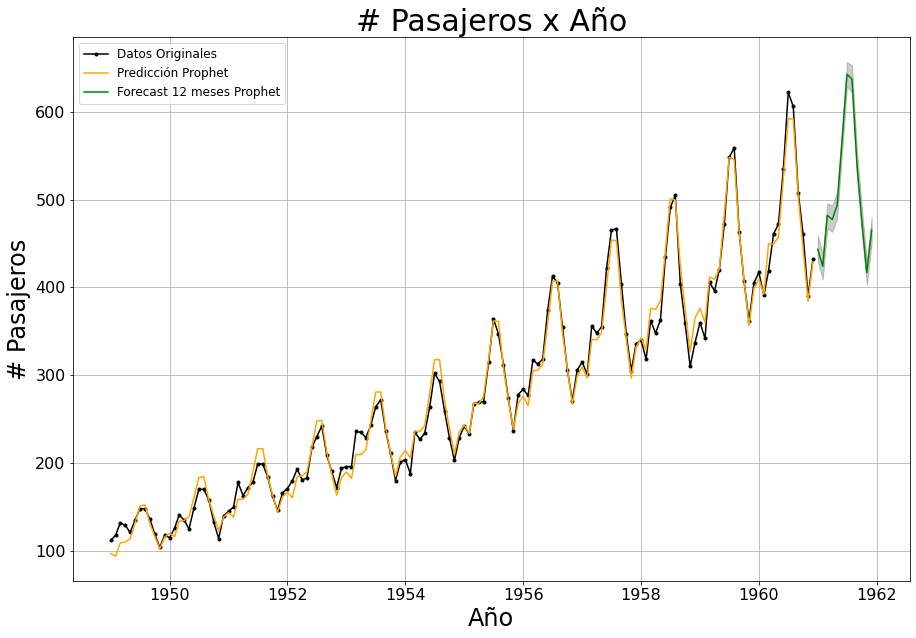

In [49]:
# mostramos los resultados finales de los datos que reducen el rmse
p_opt = {'changepoint_prior_scale':valor1opt[0],'n_changepoints':valor2opt[0]}

m3 = prophet.Prophet(**p_opt,seasonality_mode="multiplicative",
                    yearly_seasonality=True,
                    weekly_seasonality=False,
                    daily_seasonality=False)
m3.fit(df_prophet)
future = m3.make_future_dataframe(periods = 12, freq = 'm')
forecast2 = m3.predict(future)


# mostramos los datos originales y despues la predicción
plt.figure(figsize=(15,10))
plt.plot(df_prophet.ds, df_prophet.y, '.-k', label='Datos Originales')
plt.plot(df_prophet.ds[:144], forecast2.yhat[:144], 'orange', label='Predicción Prophet')
plt.plot(forecast2.ds[144:], forecast2.yhat[144:], 'g', label='Forecast 12 meses Prophet')
plt.fill_between(forecast2.ds[144:],
                forecast2.yhat_lower[144:],
                forecast2.yhat_upper[144:], color='k', alpha=.2)
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## **Pregunta 4:** Proponer un forecasting híbrido entre los modelos obtenidos en la parte a y b 





In [50]:
# COMBINACION DE SARIMAX CON PROPHET
# Definimos una grilla, con los parametros de ambos modelos.
# Los valores de la grilla son parametros que estan cerca de los valores optimos
# encontrados anteriormente.
# Posteriormente buscamos cual combinacion de parametros arroja el menor RMSE
F = (np.round(df_prophet.shape[0]*0.2)).astype(int) # Tomo 20% de la data
escalas_chpoints = list(np.linspace(0.005,0.015,3)) # rango de checkpoints     
n_chpoints = list(np.linspace(20,24,3)) # number of checkpoints

### Parametros SARIMAX
p,d,q = list([0,1]),[1],list([0,1]) # variables p,d,q  
P,D,Q,s = list([0,1,2]),[1],list([0,1,2]),[12] # variables P,D,Q  

params_grid = {'changepoint_prior_scale':escalas_chpoints,'n_changepoints': n_chpoints,
               'p':p,'d':d,'q':q,'P':P,'D':D,'Q':Q,'s':s }
grid = ParameterGrid(params_grid)
grid_search=[]

In [ ]:
# En este forecasting hibrido lo que proponemos es hacer una searchgrid, usando variables tanto de los modelos SARIMAX como prophet.
# ambos resultados son promediados para posteriormente para comparar el error cuadratico medio entre el resultado de la operacion
# y el resultado real. Despues, se utilizan los parametros que mejores resultados entregan entre ambos modelos y se hace un
# forecasting a 12 meses, usando el promedio de ambos modelos.
for pp in grid:
    m1=prophet.Prophet(changepoint_prior_scale = pp['changepoint_prior_scale'],
                       n_changepoints = int(pp['n_changepoints']),
                       seasonality_mode="multiplicative",
                       yearly_seasonality=True,
                       weekly_seasonality=False,
                       daily_seasonality=False)
    m1.fit(df_prophet[['ds','y']][0:(df_prophet.shape[0]-F)])
    forecast=m1.predict(df_prophet[['ds','y']][(df_prophet.shape[0]-F)-1:df_prophet.shape[0]])
    m2 = SARIMAX( np.asarray(df_sarima['In-Sample'][0:(df_sarima.shape[0]-F)]), 
                  order = (pp['p'],pp['d'],pp['q']), 
                  seasonal_order = (pp['P'],pp['D'],pp['Q'],pp['s']),
                  enforce_stationarity=False,
                  enforce_invertibility=False )
    results = m2.fit()
    forecastn  = results.predict(start = (df_sarima.shape[0]-F)-1, end = df_sarima.shape[0]-1, dynamic = False)
    time_date = df_sarima['Fecha'][(df_sarima.shape[0]-F)-1:df_sarima.shape[0]]
    real_value = df_sarima['Pasajeros'][(df_sarima.shape[0]-F)-1:df_sarima.shape[0]]
    
    mean_aproximation = (forecastn + forecast.yhat)/2.
    rmse = np.sqrt(mean_squared_error(real_value, mean_aproximation))

    validacion_grilla=pd.DataFrame(columns=['CPPS','nCP','p-d-q','P-D-Q-s','rmse'])
    validacion_grilla.loc[0,'CPPS'] = pp['changepoint_prior_scale']
    validacion_grilla.loc[0,'nCP'] = pp['n_changepoints']
    validacion_grilla.loc[0,'p-d-q'] = (pp['p'],pp['d'],pp['q'])
    validacion_grilla.loc[0,'P-D-Q-s'] = (pp['P'],pp['D'],pp['Q'],pp['s'])
    validacion_grilla.loc[0,'rmse'] = rmse
    grid_search.append(validacion_grilla)


In [52]:
out_grilla=pd.concat(grid_search)
out_grilla.sort_values(by='rmse', inplace=True)
valor1opt=out_grilla.head(1)['CPPS'].values
valor2opt=out_grilla.head(1)['nCP'].values
valor3opt=out_grilla.head(1)['p-d-q'].values
valor4opt=out_grilla.head(1)['P-D-Q-s'].values
out_grilla.head(1)

,CPPS,nCP,p-d-q,P-D-Q-s,rmse
0,0.015,20.000,"(0, 1, 0)","(1, 1, 2, 12)",18.805


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/3toh0rpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bfp2ekp/ingrjwb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88730', 'data', 'file=/tmp/tmp9bfp2ekp/3toh0rpt.json', 'init=/tmp/tmp9bfp2ekp/ingrjwb4.json', 'output', 'file=/tmp/tmp9bfp2ekp/prophet_modelgs2p_n5c/prophet_model-20221102203828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:38:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


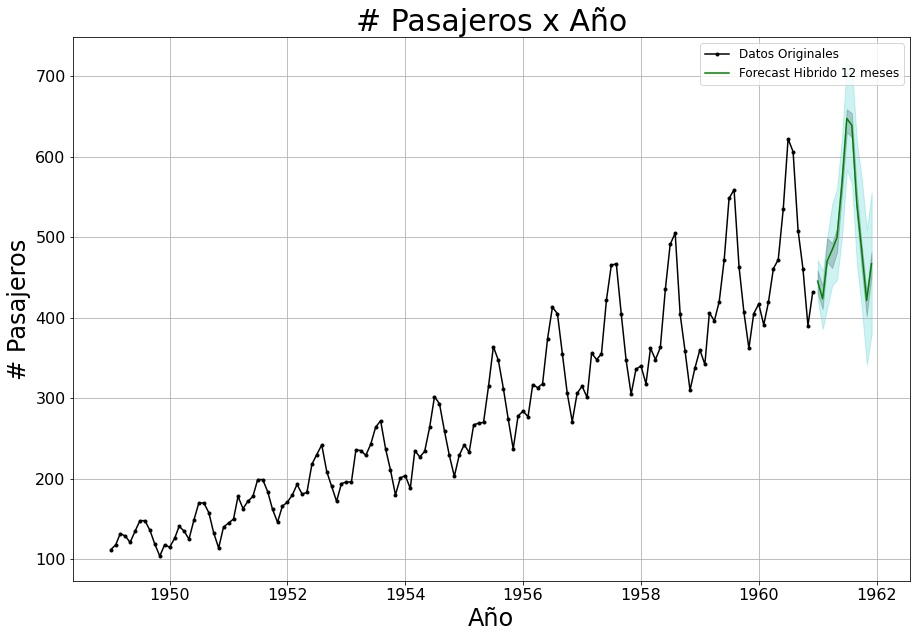

In [53]:
# muestro los resultados finales del forecast Hybrido
# SARIMAX
modelo_final = SARIMAX( np.asarray(df_sarima_fore.Pasajeros), 
                        order = valor3opt[0], 
                        seasonal_order = valor4opt[0],
                        enforce_stationarity=False,
                        enforce_invertibility=False )

results = modelo_final.fit()
forecast1 = results.get_forecast(12)
time_date = data['Fecha'][144:]
pred_ci = forecast1.conf_int()

# prophet
p_opt = {'changepoint_prior_scale':valor1opt[0],'n_changepoints':int(valor2opt[0])}
m3 = prophet.Prophet(**p_opt,seasonality_mode="multiplicative",
                    yearly_seasonality=True,
                    weekly_seasonality=False,
                    daily_seasonality=False)
m3.fit(df_prophet)
future = m3.make_future_dataframe(periods = 12, freq = 'm')
forecast2 = m3.predict(future)

forecast_final = (forecast1.predicted_mean + forecast2.yhat[144:])/2

# mistramos los datos iriginales y despues la prediccion
plt.figure(figsize=(15,10))
plt.plot(df_prophet.ds, df_prophet.y, '.-k', label='Datos Originales')
plt.plot(forecast2.ds[144:], forecast_final, 'g', label='Forecast Hibrido 12 meses')
plt.fill_between(forecast2.ds[144:],
                 forecast2.yhat_lower[144:],
                 forecast2.yhat_upper[144:], color='k', alpha=.2)
plt.fill_between(time_date,
                pred_ci[:, 0],
                pred_ci[:, 1], color='c', alpha=.2)
plt.title('# Pasajeros x Año', fontsize=30)
plt.xlabel('Año',fontsize=24)
plt.ylabel('# Pasajeros',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()